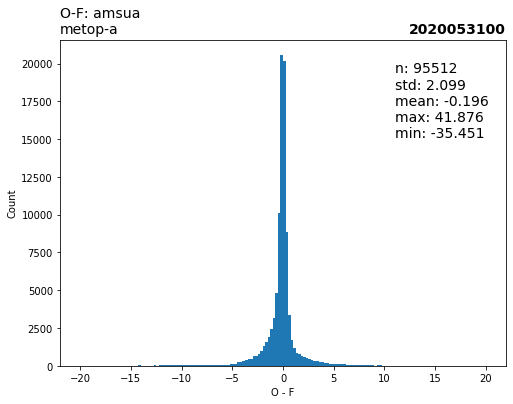

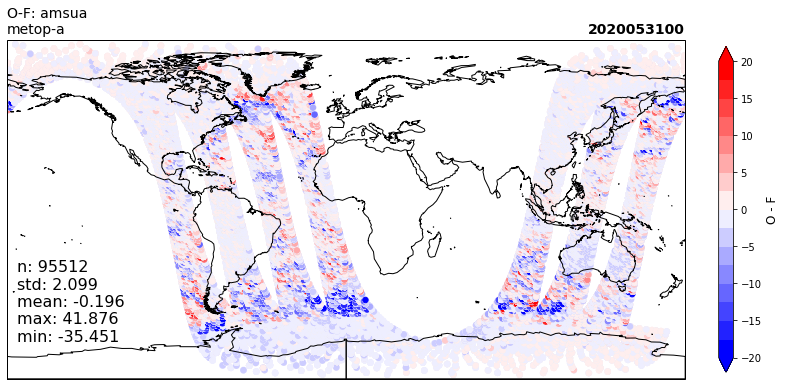

In [2]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import argparse
import yaml
from textwrap import wrap

# parser = argparse.ArgumentParser(description='Plot histogram and spatial plot with GSI diagnostic files.')          
# parser.add_argument('-y', '--yaml', type=str,                                                                                                        
#                     help='path to YAML file to run the account.', required=True)

# args = parser.parse_args()

# YAML = args.yaml

file = open('test_YAML.yaml')
parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)


##################################################################

def get_metadata(data_path):
    """
    Input: path to data
    Output:
        var: variable being analyzed
        date: date 'YYYYMMDDHH'
        hour: hour HH (zulu)
        file_type: either ges or anl
    """
    if data_path.split('/')[-1].split('.')[0].split('_')[1] == 'conv':
        
        split = data_path.split('/')[-1].split('.')
        var = split[0].split('_')[2]
        date = split[1].split('_')[0]
        hour = date[-2:]
        file_type = split[0].split('_')[-1]

        return var, date, hour, file_type
    
    else:
        split = data_path.split('/')[-1].split('.')
        sensor = split[0].split('_')[1]
        satellite = split[0].split('_')[2]
        date = split[1].split('_')[0]
        hour = date[-2:]
        file_type = split[0].split('_')[-1]

        return sensor, satellite, date, hour, file_type
    
def get_obs_type(obs_id):
    
    obs_indicators = {
        120: "Rawinsonde",
        126: "RASS",
        130: "Aircraft: AIREP and PIREP",
        131: "Aircraft: AMDAR",
        132: "Flight-Level Reconnaissance and Profile Dropsonde",
        133: "Aircraft: MDCRS ACARS",
        134: "Aircraft: TAMDAR",
        135: "Aircraft: Canadian AMDAR",
        153: "GPS-Integrated Precipitable Water",
        180: "Surface Marine w/ Station Pressure (Ship, Buoy, C-MAN, Tide Guage)",
        181: "Surface Land w/ Station Pressure (Synoptic, METAR)",
        182: "Splash-Level Dropsonde Over Ocean",
        183: "Surface Marine or Land - Missing Station Pressure",
        187: "Surface Land - Missing Station Pressure",
        210: "Synthetic Tropical Cyclone",
        220: "Rawinsonde",
        221: "PIBAL",
        224: "NEXRAD Vertical Azimuth Display",
        228: "Wind Profiler: JMA",
        229: "Wind Profiler: PIBAL",
        230: "Aircraft: AIREP and PIREP",
        231: "Aircraft: AMDAR",
        232: "Flight-Level Reconnaissance and Profile Dropsonde",
        233: "Aircraft: MDCRS ACARS",
        234: "Aircraft: TAMDAR",
        235: "Aircraft: Canadian AMDAR",
        242: "JMA IR (Longwave) and Visible Cloud Drift Below 850mb (GMS, MTSAT, HIMAWARI)",
        243: "EUMETSAT IR (Longwave) and Visible Cloud Drift Below 850mb (METEOSAT)",
        245: "NESDIS IR (Longwave) Cloud Drift (All Levels)",
        246: "NESDIS Imager Water Vapor (All Levels) - Cloud Top (GOES)",
        250: "JMA Imager Water Vapor (All Levels) - Cloud Top & Deep Layer (GMS, MTSAT, HIMAWARI)",
        251: "NESDIS Visible Cloud Drift (All Levels) (GOES)",
        252: "JMA IR (Longwave) and Visible Cloud Drift Above 850mb (GMS, MTSAT, HIMAWARI)",
        253: "EUMETSAT IR (Longwave) and Visible Cloud Drift Above 850mb (METEOSAT)",
        254: "EUMETSAT Imager Water Vapor (All Levels) - Cloud Top & Deep Layer (METEOSAT)",
        257: "MODI/POES IR (Longwave) Cloud Drift (All Levels) (AQUA, TERRA)",
        258: "MODIS/POES Imager Water Vapor (All Levels) - Cloud Top (AQUA, TERRA)",
        259: "MODIS/POES Imager Water Vapor (All Levels) - Deep Layer (AQUA, TERRA)",
        280: "Surface Marine w/ Station Pressure (Ship, Buoy, C-MAN, Tide Guage)",
        281: "Surface Land w/ Station Pressure (Synoptic, METAR)",
        282: "ATLAS Buoy",
        284: "Surface Marine or Land - Missing Station Pressure",
        287: "Surface Land (METAR) - Missing Station Pressure",
        289: "SUPEROBED (1.0 Lat/Lon) Scatterometer Winds over Ocean",
        290: "Non-SUPEROBED Scatterometer Winds over Ocean"
    }
    
    if (obs_id in obs_indicators.keys()) == True:	
        return obs_indicators[obs_id]
    else:
        return str(obs_id)

def calculate_stats(diff):
    mean = np.mean(diff)
    var_list = [(x-mean)**2 for x in diff]
    variance = np.sum(var_list)/(len(var_list)-1)
    std = np.sqrt(variance)
    mx = max(diff)
    mn = min(diff)
    
    return mean, std, mx, mn

def plot_labels(meta_data):
    
    if list(meta_data.keys())[0] == 'Variable':
    
        if meta_data['File_type'] == 'ges':
            xlabel = 'O - F'
            left_title = 'O-F: %s \n%s' % (meta_data['Variable'], meta_data['Obs_description'])
            right_title = '%s' % meta_data['Date']
            save_file = '%s_%s_%s_O_minus_F_spatial.png' % (meta_data['Date'], meta_data['Variable'], meta_data['Obs_ID'])

        if meta_data['File_type'] == 'anl':
            xlabel = 'O - A'
            left_title = 'O-A: %s \n%s' % (meta_data['Variable'], meta_data['Obs_description'])
            right_title = '%s' % meta_data['Date']
            save_file = '%s_%s_%s_O_minus_A_spatial.png' % (meta_data['Date'], meta_data['Variable'], meta_data['Obs_ID'])
        
    if list(meta_data.keys())[0] == 'Satellite':
        if meta_data['File_type'] == 'ges':
            xlabel = 'O - F'
            left_title = 'O-F: %s \n%s' % (meta_data['Sensor'], meta_data['Satellite'])
            right_title = '%s' % meta_data['Date']
            save_file = '%s_%s_%s_O_minus_F_spatial.png' % (meta_data['Date'], meta_data['Sensor'], meta_data['Satellite'])
            
        if meta_data['File_type'] == 'anl':
            xlabel = 'O - A'
            left_title = 'O-A: %s \n%s' % (meta_data['Sensor'], meta_data['Satellite'])
            right_title = '%s' % meta_data['Date']
            save_file = '%s_%s_%s_O_minus_A_spatial.png' % (meta_data['Date'], meta_data['Sensor'], meta_data['Satellite'])
            
    labels = {'x': xlabel,
              'lt': left_title,
              'rt': right_title,
              'save': save_file
             }
            
            
    return labels

def plot_histogram(diff, bins, meta_data):
    # get count and calculate mean and standard deviation of diff
    n = len(diff) 
    mean, std, mx, mn = calculate_stats(diff)
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    plt.hist(diff, bins=bins)
    
    if list(meta_data.keys())[0] == 'Variable':
        if meta_data['Variable'] == 'q':
            t = ('n: %s\nstd: %s\nmean: %s' % (n,np.round(std,6),np.round(mean,6)))
            ax.text(0.75,.8, t, fontsize=14, transform=ax.transAxes)
    else:
        t = ('n: %s\nstd: %s\nmean: %s\nmax: %s\nmin: %s' % (n,np.round(std,3),np.round(mean,3), np.round(mx,3), np.round(mn,3)))
        ax.text(0.75,.7, t, fontsize=14, transform=ax.transAxes)
    
    labels = plot_labels(meta_data)
        
    plt.xlabel(labels['x'])
    plt.ylabel('Count')
    
    title_split = labels['lt'].split('\n')
    plt.title("%s\n%s" % (title_split[0], '\n'.join(wrap(title_split[-1], 40))), loc='left', fontsize=14)
    plt.title(labels['rt'], loc='right', fontweight='semibold', fontsize=14)
#     plt.savefig(labels['save'], bbox_inches='tight', pad_inches=0.1)
    
    return 0

def plot_spatial(diff, bounds, meta_data, lons, lats):
    
    n = len(diff) 
    mean, std, mx, mn = calculate_stats(diff)
    
    plt.figure(figsize=(15,12))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    ax.add_feature(cfeature.GSHHSFeature(scale='auto'))
    ax.set_extent([-180, 180, -90, 90])
    norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256)
    
    cs = plt.scatter(lons, lats, c=diff, s=30,
                norm=norm, cmap='bwr', #edgecolors='gray', linewidth=0.25,
                transform=ccrs.PlateCarree())
    
    if list(meta_data.keys())[0] == 'Variable':
        if meta_data['Variable'] == 'q':
            t = ('n: %s\nstd: %s\nmean: %s' % (n,np.round(std,6),np.round(mean,6)))
            ax.text(-175, -70, t, fontsize=16, transform=ccrs.PlateCarree())
    else:
        t = ('n: %s\nstd: %s\nmean: %s\nmax: %s\nmin: %s' % (n,np.round(std,3),np.round(mean,3), np.round(mx,3), np.round(mn,3)))
        ax.text(-175, -70, t, fontsize=16, transform=ccrs.PlateCarree())

    labels = plot_labels(meta_data)
    
    cb = plt.colorbar(cs, shrink=0.5, pad=.04, extend='both')
    cb.set_label(labels['x'], fontsize=12)
    
    title_split = labels['lt'].split('\n')
    plt.title("%s\n%s" % (title_split[0], '\n'.join(wrap(title_split[-1], 70))), loc='left', fontsize=14)
    plt.title(labels['rt'], loc='right', fontweight='semibold', fontsize=14)
#     plt.savefig(labels['save'], bbox_inches='tight', pad_inches=0.1)
    
    return 0
    
    
##################################################################    


def main(parsed_yaml_file):
    
    if parsed_yaml_file['conventional input']['path'] != None:
        
        nc_file = parsed_yaml_file['conventional input']['path']
        var, date, hour, file_type = get_metadata(nc_file)

        obs_id = parsed_yaml_file['conventional inpute']['observation id']

        if obs_id != None:

            obs_descript = get_obs_type(obs_id)

            meta_data = {"Variable": var,
                         "Date": date,
                         "Hour": hour,
                         "File_type": file_type,
                         "Obs_ID": obs_id,
                         "Obs_description": obs_descript
                        }
        else:
            meta_data = {"Variable": var,
                         "Date": date,
                         "Hour": hour,
                         "File_type": file_type,
                         "Obs_ID": "All Obs Types",
                         "Obs_description": "All Obs Types"
                        }

        ## Address uv data    
        if meta_data['Variable'] == 'uv':
            ## Read data
            f = Dataset(nc_file, mode='r')

            lons = f.variables['Longitude'][:]
            lats = f.variables['Latitude'][:]
            u_diff = f.variables['u_Obs_Minus_Forecast_adjusted'][:]
            v_diff = f.variables['v_Obs_Minus_Forecast_adjusted'][:]
            o_type = f.variables['Observation_Type'][:]
            f.close()

            ## Find data with indicated observation type
            if obs_id != None:    
                idx = np.where(o_type == obs_id)
                u_diff = u_diff[idx]
                v_diff = v_diff[idx]

                lons = lons[idx]
                lats = lats[idx]

                if u_diff.size == 0 or v_diff == 0:
                    print("No observations for %s from Observation ID: %s" % (var, obs_id))

            bins = np.arange(-20,20.1,0.1)
            plot_histogram(u_diff, bins, meta_data) #will need to fix titles
            plot_histogram(v_diff, bins, meta_data) #will need to fix titles

            bounds = np.arange(-10,12.5,2.5)
            plot_spatial(u_diff, bounds, meta_data, lons, lats)
            plot_spatial(v_diff, bounds, meta_data, lons, lats)


        else:    
            ## Read data
            f = Dataset(nc_file, mode='r')

            lons = f.variables['Longitude'][:]
            lats = f.variables['Latitude'][:]
            diff  = f.variables['Obs_Minus_Forecast_adjusted'][:]
            o_type = f.variables['Observation_Type'][:]
            f.close()


            ## Find data with indicated observation type
            if obs_id != None:    
                idx = np.where(o_type == obs_id)
                diff = diff[idx]

                lons = lons[idx]
                lats = lats[idx]

                if diff.size == 0:
                    print("No observations for %s from Observation ID: %s" % (var, obs_id))

            # Temperature
            if var == 't':
                bins = np.arange(-10,10.1,0.1)
                plot_histogram(diff, bins, meta_data)

                bounds = np.arange(-10,12.5,2.5)
                plot_spatial(diff, bounds, meta_data, lons, lats)

            # Specific Humidity
            if var == 'q':
                bins = np.arange(-0.01,0.0101,0.0001)
                plot_histogram(diff, bins, meta_data)

                bounds = np.arange(-0.01,0.0125,0.0025)
                plot_spatial(diff, bounds, meta_data, lons, lats)

            # Pressure
            if var == 'ps':
                bins = np.arange(-500,510,10)
                plot_histogram(diff, bins, meta_data)

                bounds = np.arange(-500,510,100)
                plot_spatial(diff, bounds, meta_data, lons, lats)
                
                # SST
            if var == 'sst':
                bins = np.arange(-5,5.1,0.1)
                plot_histogram(diff, bins, meta_data)

                bounds = np.arange(-5,6,1)
                plot_spatial(diff, bounds, meta_data, lons, lats)

            # Precipitable Water
            if var == 'pw':
                bins = np.arange(-10,10.5,0.5)
                plot_histogram(diff, bins, meta_data)

                bounds = np.arange(-10,12,2)
                plot_spatial(diff, bounds, meta_data, lons, lats)

            # GPS
            if var == 'gps':
                bins = np.arange(-0.005,0.0051,0.0001)
                plot_histogram(diff, bins, meta_data)

                bounds = np.arange(-0.005,0.0051,0.001)
                plot_spatial(diff, bounds, meta_data, lons, lats)

            # Tropical Cyclone Pressure
            if var == 'tcp':
                bins = np.arange(-5,5.1,0.1)
                plot_histogram(diff, bins, meta_data)

                bounds = np.arange(-5,6,1)
                plot_spatial(diff, bounds, meta_data, lons, lats)
                
                
                
    if parsed_yaml_file['satellite input']['path'] != None:
    
        nc_file = parsed_yaml_file['satellite input']['path']
        sensor, satellite, date, hour, file_type = get_metadata(nc_file)
        
        meta_data = {"Satellite": satellite,
                     "Sensor": sensor,
                     "Date": date,
                     "Hour": hour,
                     "File_type": file_type,
                    }

        # Read Data
        f = Dataset(nc_file, mode='r')
        lons = f.variables['Longitude'][:]
        lats = f.variables['Latitude'][:]
        qc = f.variables['QC_Flag'][:]
        channel_idx = f.variables['Channel_Index'][:]
        diff  = f.variables['Obs_Minus_Forecast_adjusted'][:]
        f.close()

        VALID_QC_FLAGS = list()

        # Checks to see if qc flags included in YAML file are actually in data set.
        # If they are not, prompt user which flags are excluded 
        for i in parsed_yaml_file['satellite input']['qc flag']:
            if (i in qc) == True:
                VALID_QC_FLAGS.append(i)
            else:
                print('QC flag %s is not in data set.' % i)


        # Finds indexes where valid QC flags and channels are in data
        flag_i = np.isin(qc, VALID_QC_FLAGS)
        chan_i = np.isin(channel_idx, parsed_yaml_file['satellite input']['channel'])

        # Address each scenario:
        # Valid flags and channels included in YAML
        if sum(flag_i) > 0 and sum(chan_i) > 0:
            idx = np.where((chan_i) & (flag_i))

        # Valid flags included in YAML, but no channels
        elif sum(flag_i) > 0 and sum(chan_i) == 0:
            idx = np.where(flag_i)

        # Channels included in YAML, but no valid QC flags
        elif sum(flag_i) == 0 and sum(chan_i) > 0:
            idx = np.where(chan_i)

        # No channels or valid QC flags included
        else:
            idx = np.where(diff)


        # Apply indexes to diff, lons, and lats for appropariate indexes
        diff = diff[idx]
        lons = lons[idx]
        lats = lats[idx]
        
        bins = np.arange(-20,20.25,0.25)
        plot_histogram(diff, bins, meta_data)

        bounds = np.arange(-20,22.5,2.5)
        plot_spatial(diff, bounds, meta_data, lons, lats)
                
        
    return None


main(parsed_yaml_file)



In [ ]:
import yaml

# parser = argparse.ArgumentParser(description='Plot histogram and spatial plot with GSI diagnostic files.')          
# parser.add_argument('-y', '--yaml', type=str,                                                                                                        
#                     help='path to YAML file to run the account.', required=True)

# args = parser.parse_args()

# YAML = args.yaml

file = open('test_YAML.yaml')
parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)

# try:
#     qc_flags = re.split(r'\W+', parsed_yaml_file['satellite input']['qc flag'])
#     qc_flags = [int(i) for i in qc_flags]
# except:
#     qc_flags = [parsed_yaml_file['satellite input']['qc flag']


# qc_flags

parsed_yaml_file['satellite input']



## Addressing QC flags
Biggest issue here is checking to see if the QC flags are even there. Maybe a quick for loop that iterates through the list of numbers and prints if it is not in?

In [ ]:
import re
import yaml
from collections import Counter
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import spatial
import cartopy.crs as ccrs
import cartopy.feature as cfeature


file = open('test_YAML.yaml')
parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)


if parsed_yaml_file['satellite input']['path'] != None:
    
    nc_file = parsed_yaml_file['satellite input']['path']
#     var, date, hour, file_type = get_metadata(nc_file)

    # Read Data
    f = Dataset(nc_file, mode='r')
    lons = f.variables['Longitude'][:]
    lats = f.variables['Latitude'][:]
    qc = f.variables['QC_Flag'][:]
    channel_idx = f.variables['Channel_Index'][:]
    diff  = f.variables['Obs_Minus_Forecast_adjusted'][:]
    f.close()
    
    VALID_QC_FLAGS = list()
    
    # Checks to see if qc flags included in YAML file are actually in data set.
    # If they are not, prompt user which flags are excluded 
    for i in parsed_yaml_file['satellite input']['qc flag']:
        if (i in qc) == True:
            VALID_QC_FLAGS.append(i)
        else:
            print('QC flag %s is not in data set.' % i)

        
    # Finds indexes where valid QC flags and channels are in data
    flag_i = np.isin(qc, VALID_QC_FLAGS)
    chan_i = np.isin(channel_idx, parsed_yaml_file['satellite input']['channel'])
    
    # Address each scenario:
    # Valid flags and channels included in YAML
    if sum(flag_i) > 0 and sum(chan_i) > 0:
        idx = np.where((chan_i) & (flag_i))
    
    # Valid flags included in YAML, but no channels
    elif sum(flag_i) > 0 and sum(chan_i) == 0:
        idx = np.where(flag_i)
        print(idx)
        
    # Channels included in YAML, but no valid QC flags
    elif sum(flag_i) == 0 and sum(chan_i) > 0:
        idx = np.where(chan_i)
    
    # No channels or valid QC flags included
    else:
        idx = np.where(diff)
    
    
    # Apply indexes to diff, lons, and lats for appropariate indexes
    diff = diff[idx]
    lons = lons[idx]
    lats = lats[idx]
        
        
    bins = np.arange(-20,20.25,0.25)

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    plt.hist(diff, bins=bins)
    
    plt.figure(figsize=(15,12))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    ax.add_feature(cfeature.GSHHSFeature(scale='auto'))
    ax.set_extent([-180, 180, -90, 90])
    norm = mcolors.BoundaryNorm(boundaries=bins, ncolors=256)

    cs = plt.scatter(lons, lats, c=diff, s=10, 
                norm=norm, cmap='bwr', #edgecolors='gray', linewidth=0.25,
                transform=ccrs.PlateCarree())
    cb = plt.colorbar(cs, shrink=0.5, pad=.04, extend='both')
    cb.set_label('O-F', fontsize=12)
        


    
    
    

In [ ]:
file = open('test_YAML.yaml')
parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)

if parsed_yaml_file['conventional input']['path'] != None:

    var, date, hour, file_type = get_metadata(nc_file)
    obs_id = parsed_yaml_file['conventional inpute']['observation id']

    if obs_id != None:

        obs_descript = get_obs_type(obs_id)

        meta_data = {"Variable": var,
                     "Date": date,
                     "Hour": hour,
                     "File_type": file_type,
                     "Obs_ID": obs_id,
                     "Obs_description": obs_descript
                    }
    else:
        meta_data = {"Variable": var,
                     "Date": date,
                     "Hour": hour,
                     "File_type": file_type,
                     "Obs_ID": "All Obs Types",
                     "Obs_description": "All Obs Types"
                    }
        
    ## Address uv data    
    if meta_data['Variable'] == 'uv':
        ## Read data
        f = Dataset(nc_file, mode='r')

        lons = f.variables['Longitude'][:]
        lats = f.variables['Latitude'][:]
        u_diff = f.variables['u_Obs_Minus_Forecast_adjusted'][:]
        v_diff = f.variables['v_Obs_Minus_Forecast_adjusted'][:]
        o_type = f.variables['Observation_Type'][:]
        f.close()
        
        ## Find data with indicated observation type
        if obs_id != None:    
            idx = np.where(o_type == obs_id)
            u_diff = u_diff[idx]
            v_diff = v_diff[idx]

            lons = lons[idx]
            lats = lats[idx]

            if u_diff.size == 0 or v_diff == 0:
                print("No observations for %s from Observation ID: %s" % (var, obs_id))
        
        bins = np.arange(-20,20.1,0.1)
        plot_histogram(u_diff, bins, meta_data) #will need to fix titles
        plot_histogram(v_diff, bins, meta_data) #will need to fix titles

        bounds = np.arange(-10,12.5,2.5)
        plot_spatial(u_diff, bounds, meta_data, lons, lats)
        plot_spatial(v_diff, bounds, meta_data, lons, lats)
        
        
    else:    
        ## Read data
        f = Dataset(nc_file, mode='r')

        lons = f.variables['Longitude'][:]
        lats = f.variables['Latitude'][:]
        diff  = f.variables['Obs_Minus_Forecast_adjusted'][:]
        qc_flags = f.variables['QC_Flag'][:]
        o_type = f.variables['Observation_Type'][:]
        f.close()


        ## Find data with indicated observation type
        if obs_id != None:    
            idx = np.where(o_type == obs_id)
            diff = diff[idx]

            lons = lons[idx]
            lats = lats[idx]

            if diff.size == 0:
                print("No observations for %s from Observation ID: %s" % (var, obs_id))

        # Temperature
        if var == 't':
            bins = np.arange(-10,10.1,0.1)
            plot_histogram(diff, bins, meta_data)

            bounds = np.arange(-10,12.5,2.5)
            plot_spatial(diff, bounds, meta_data, lons, lats)

        # Specific Humidity
        if var == 'q':
            bins = np.arange(-0.01,0.0101,0.0001)
            plot_histogram(diff, bins, meta_data)

            bounds = np.arange(-0.01,0.0125,0.0025)
            plot_spatial(diff, bounds, meta_data, lons, lats)

        # Pressure
        if var == 'ps':
            bins = np.arange(-500,510,10)
            plot_histogram(diff, bins, meta_data)

            bounds = np.arange(-500,510,100)
            plot_spatial(diff, bounds, meta_data, lons, lats)
        
        # SST
        if var == 'sst':
            bins = np.arange(-5,5.1,0.1)
            plot_histogram(diff, bins, meta_data)
            
            bins = np.arange(-5,6,1)
            plot_spatial(diff, bounds, meta_data, lons, lats)
            
        # Precipitable Water
        if var == 'pw':
            bins = np.arange(-10,10.5,0.5)
            plot_histogram(diff, bins, meta_data)
            
            bins = np.arange(-10,12,2)
            plot_spatial(diff, bounds, meta_data, lons, lats)
        
        # GPS
        if var == 'gps':
            bins = np.arange(-0.005,0.0051,0.0001)
            plot_histogram(diff, bins, meta_data)
            
            bins = np.arange(-0.005,0.0051,0.001)
            plot_spatial(diff, bounds, meta_data, lons, lats)
        
        # Tropical Cyclone Pressure
        if var == 'tcp':
            bins = np.arange(-5,5.1,0.1)
            plot_histogram(diff, bins, meta_data)
            
            bins = np.arange(-5,6,1)
            plot_spatial(diff, bounds, meta_data, lons, lats)
            
        
            
    
if parsed_yaml_file['satellite input']['path'] != None:
    print('hi')
    

In [ ]:
import numpy as np
from netCDF4 import Dataset
from collections import Counter
import glob

path = '/scratch1/NCEPDEV/stmp2/Cory.R.Martin/ICs_tmp/v16para/gdas.20200531/00/'
nc_file = path+'diag_amsua_metop-a_ges.2020053100.nc4'

# nc_files = sorted(glob.glob(path+'*ges.*nc4'))

# for nc_file in nc_files:
print(nc_file)
f = Dataset(nc_file, mode='r')
# print(f)
# print('====================================================================')
lons = f.variables['Longitude'][:]
lats = f.variables['Latitude'][:]
qc_flags = f.variables['QC_Flag'][:]
channel_idx = f.variables['Channel_Index'][:]
diff  = f.variables['Obs_Minus_Forecast_adjusted'][:]
f.close()

print(satinfo_chan)

channels = [1,2,3]
chan_i = np.isin(channel_idx, channels)

flags = None
flags_i = np.isin(qc_flags, flags)

flags_i
# if flags == []:
#     print('hello')

idx = np.where((chan_i) & (flags_i))
idx
# idx = np.where((channel_idx == channels) & (qc_flags != 0))

# print(idx)
# diff = diff[idx]

# print(len(diff))

# lons = lons[idx]
# lats = lats[idx]

# print(Counter(qc_flags))
# print(qc_flags)
# print(diff.shape)
# print(nchans)
# print(freq)
# print(wave)

In [ ]:
##########################

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import spatial
import cartopy.crs as ccrs
import cartopy.feature as cfeature

bins = np.arange(-10,10.5,0.5)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.hist(diff, bins=bins)

plt.figure(figsize=(15,12))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.add_feature(cfeature.GSHHSFeature(scale='auto'))
ax.set_extent([-180, 180, -90, 90])
norm = mcolors.BoundaryNorm(boundaries=bins, ncolors=256)

cs = plt.scatter(lons, lats, c=diff, s=10, 
            norm=norm, cmap='bwr', #edgecolors='gray', linewidth=0.25,
            transform=ccrs.PlateCarree())
cb = plt.colorbar(cs, shrink=0.5, pad=.04, extend='both')
cb.set_label('O-F', fontsize=12)